In [43]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
import joblib
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, 
                            roc_auc_score, roc_curve, classification_report, confusion_matrix, auc)
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import os
import warnings
from datetime import datetime

# Parameters
needle_height = '1.3'
conjugate = 'chlr'
n_trials = 50
dataset_key = f"{needle_height}_{conjugate}" # Dataset name

# Create output directory with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
output_dir = f"results/{dataset_key}_{timestamp}"
os.makedirs(output_dir, exist_ok=True)

# Base directory
base_dir = r"D:\20241129_solid_nN_1.3_2.4_mdck_siRNA_tnsfn_chlr\20241129_solid_nN_1.3_mdck_chlr_dataset"
dataset_path = base_dir + r"\solid_1.3_chlr_cell_level.csv"


In [44]:
# Feature Definition

# Define morphological and intensity features
cell_morph_features = [
    'area', 'perimeter', 'major_axis_length', 'minor_axis_length', 
    'eccentricity', 'circularity', 'solidity', 'orientation'
]

nuclear_morph_features = [
    'nuclear_area', 'nuclear_perimeter', 'nuclear_major_axis_length', 
    'nuclear_minor_axis_length', 'nuclear_eccentricity', 'nuclear_circularity', 
    'nuclear_solidity', 'nuclear_orientation'
]

channel_feature_suffixes = [
    'intensity_p10', 'intensity_p25', 'intensity_p50', 
    'intensity_p75', 'intensity_p90'
]

protein_channels = ['actin', 'caveolin', 'clathrin_hc', 'nuclei']

# Generate feature list with caveolin features first to ensure dominance
feature_list = cell_morph_features + nuclear_morph_features

for suffix in channel_feature_suffixes:
    feature_list.append(f"caveolin_{suffix}")

for ch in protein_channels:
    if ch != 'caveolin':
        for suffix in channel_feature_suffixes:
            feature_list.append(f"{ch}_{suffix}")

print(feature_list)


['area', 'perimeter', 'major_axis_length', 'minor_axis_length', 'eccentricity', 'circularity', 'solidity', 'orientation', 'nuclear_area', 'nuclear_perimeter', 'nuclear_major_axis_length', 'nuclear_minor_axis_length', 'nuclear_eccentricity', 'nuclear_circularity', 'nuclear_solidity', 'nuclear_orientation', 'caveolin_intensity_p10', 'caveolin_intensity_p25', 'caveolin_intensity_p50', 'caveolin_intensity_p75', 'caveolin_intensity_p90', 'actin_intensity_p10', 'actin_intensity_p25', 'actin_intensity_p50', 'actin_intensity_p75', 'actin_intensity_p90', 'clathrin_hc_intensity_p10', 'clathrin_hc_intensity_p25', 'clathrin_hc_intensity_p50', 'clathrin_hc_intensity_p75', 'clathrin_hc_intensity_p90', 'nuclei_intensity_p10', 'nuclei_intensity_p25', 'nuclei_intensity_p50', 'nuclei_intensity_p75', 'nuclei_intensity_p90']


In [45]:
# Data Processing

def process_dataset(dataset_path, dataset_key, area_percentiles=(2, 98)):
    print(f"\n=== Processing {dataset_key} ===")

    # Extract conjugate type from dataset_key
    conjugate_type = dataset_key.split('_')[1]

    # Set the correct intensity column name
    intensity_column = f"{conjugate_type}_intensity_mean"
    intensity_threshold = 300

    print(f"Using intensity column: {intensity_column}")

    # Load dataset
    df = pd.read_csv(dataset_path)

    # Apply area filtering based on percentiles
    cell_area_min, cell_area_max = np.percentile(df['area'], area_percentiles)
    nuclear_area_min, nuclear_area_max = np.percentile(df['nuclear_area'], area_percentiles)

    # Filter cells based on area thresholds
    df_filtered = df[(df['area'] >= cell_area_min) & (df['area'] <= cell_area_max)].copy()

    # Filter nuclei based on area thresholds
    nuclei_threshold = (
        (df_filtered['nuclear_area'] >= nuclear_area_min) & 
        (df_filtered['nuclear_area'] <= nuclear_area_max)
    )

    nuclear_cols = [col for col in df_filtered.columns if col.startswith('nuclear_')]
    df_filtered.loc[~nuclei_threshold, nuclear_cols] = np.nan

    # Create binary target variable
    df_filtered['conjugate_category'] = (df_filtered[intensity_column] > intensity_threshold).astype(int)

    print("Unique conjugate_category values:", df_filtered['conjugate_category'].unique())
    print("Value counts:\n", df_filtered['conjugate_category'].value_counts())

    # Define X, y, and images
    X = df_filtered[feature_list]
    y = df_filtered['conjugate_category']
    
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    images = df_filtered['image_id']
    
    return X, y_encoded, images


In [46]:
# Model Training and Evaluation

X, y_encoded, images = process_dataset(dataset_path, dataset_key)

# Dictionaries for aggregated metrics
all_fold_metrics = []
class_report_list = []
shap_values_list = []
X_test_raw_list = []
X_test_scaled_list = []
mean_fpr = np.linspace(0, 1, 100)
tprs = []
aucs = []
    
# Outer CV: Stratified Group K-Fold
outer_cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
    
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y_encoded, groups=images), start=1):
    print(f"\n=== Outer Fold {fold} ===")
    print(f"Fold {fold}: n_test={len(test_idx)}")
    print(f"Class distribution: Class 0: {np.sum(y_encoded[test_idx] == 0)}, Class 1: {np.sum(y_encoded[test_idx] == 1)}")
        
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y_encoded[train_idx], y_encoded[test_idx]
        
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_test_scaled_list.append(X_test_scaled)
        
    def objective(trial):
        params = {
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'gamma': trial.suggest_float('gamma', 0, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
            'n_estimators': trial.suggest_int('n_estimators', 50, 200)
            }
            
        model = xgb.XGBClassifier(random_state=42, **params)
            
        inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        inner_scores = []
            
        for inner_train_idx, inner_valid_idx in inner_cv.split(X_train_scaled, y_train):
            X_inner_train = X_train_scaled[inner_train_idx]
            X_inner_valid = X_train_scaled[inner_valid_idx]
            y_inner_train = y_train[inner_train_idx]
            y_inner_valid = y_train[inner_valid_idx]

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model.fit(X_inner_train, y_inner_train)
                
            y_pred_inner = model.predict(X_inner_valid)
            score = accuracy_score(y_inner_valid, y_pred_inner)
            inner_scores.append(score)
            
        return np.mean(inner_scores)
        
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    best_params = study.best_params
    best_model = xgb.XGBClassifier(random_state=42, **best_params)
    best_model.fit(X_train_scaled, y_train)
        
    # Calculate comprehensive metrics
    y_test_pred = best_model.predict(X_test_scaled)
    y_test_proba = best_model.predict_proba(X_test_scaled)
        
    # Store fold metrics
    fold_metrics = {
        "fold": fold,
        "accuracy": accuracy_score(y_test, y_test_pred),
        "f1_weighted": f1_score(y_test, y_test_pred, average='weighted'),
        "precision_weighted": precision_score(y_test, y_test_pred, average='weighted'),
        "recall_weighted": recall_score(y_test, y_test_pred, average='weighted'),
        "roc_auc": roc_auc_score(y_test, y_test_proba[:, 1])
    }
    all_fold_metrics.append(fold_metrics)
        
    # Generate class-wise metrics
    class_report = classification_report(y_test, y_test_pred, output_dict=True)
    class_report_list.append(class_report)
        
    # SHAP values calculation
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X_test_scaled)
    shap_values_list.append(shap_values)
        
    # Save model
    model_filename = f"{output_dir}/model_{dataset_key}_fold_{fold}.joblib"
    joblib.dump((best_model, scaler), model_filename)
    print(f"Model saved as {model_filename}")
        
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_test_proba[:, 1])
    roc_auc = auc(fpr, tpr)
        
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(roc_auc)
    
# After all folds complete
metrics_df = pd.DataFrame(all_fold_metrics)
avg_metrics = {
    'accuracy': metrics_df['accuracy'].mean(),
    'accuracy_std': metrics_df['accuracy'].std(),
    'f1_weighted': metrics_df['f1_weighted'].mean(),
    'f1_weighted_std': metrics_df['f1_weighted'].std(),
    'precision_weighted': metrics_df['precision_weighted'].mean(),
    'precision_weighted_std': metrics_df['precision_weighted'].std(),
    'recall_weighted': metrics_df['recall_weighted'].mean(),
    'recall_weighted_std': metrics_df['recall_weighted'].std(),
    'roc_auc': metrics_df['roc_auc'].mean(),
    'roc_auc_std': metrics_df['roc_auc'].std()
}
    
best_fold_idx = np.argmax(metrics_df['roc_auc'])
best_fold = metrics_df.iloc[best_fold_idx]['fold']
best_model_path = f"{output_dir}/model_{dataset_key}_fold_{int(best_fold)}.joblib"
best_model = joblib.load(best_model_path)

# Print results
print("\n=== Final Results ===")
print(f"Dataset: {dataset_key}")
print(f"Accuracy: {avg_metrics['accuracy']:.4f} ± {avg_metrics['accuracy_std']:.4f}")
print(f"F1 Score (weighted): {avg_metrics['f1_weighted']:.4f} ± {avg_metrics['f1_weighted_std']:.4f}")
print(f"Precision (weighted): {avg_metrics['precision_weighted']:.4f} ± {avg_metrics['precision_weighted_std']:.4f}")
print(f"Recall (weighted): {avg_metrics['recall_weighted']:.4f} ± {avg_metrics['recall_weighted_std']:.4f}")
print(f"ROC AUC: {avg_metrics['roc_auc']:.4f} ± {avg_metrics['roc_auc_std']:.4f}")
print(f"Best Fold: {best_fold}")



=== Processing 1.3_chlr ===
Using intensity column: chlr_intensity_mean
Unique conjugate_category values: [1 0]
Value counts:
 conjugate_category
0    16180
1    10745
Name: count, dtype: int64


c:\Users\ChiappiniLAB\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\ChiappiniLAB\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\ChiappiniLAB\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
[I 2025-04-13 20:51:15,152] A new study created in memory with name: no-name-e86d2bcf-afaf-4dfa-b8f3-3649a37bce30



=== Outer Fold 1 ===
Fold 1: n_test=5031
Class distribution: Class 0: 2949, Class 1: 2082


[I 2025-04-13 20:51:15,677] Trial 0 finished with value: 0.8202703937151732 and parameters: {'max_depth': 4, 'learning_rate': 0.03395167295819496, 'subsample': 0.9696083373297532, 'colsample_bytree': 0.8374636664285477, 'min_child_weight': 9, 'gamma': 3.056909039315938, 'reg_alpha': 8.00108535489051, 'reg_lambda': 4.354357718294474, 'n_estimators': 119}. Best is trial 0 with value: 0.8202703937151732.
[I 2025-04-13 20:51:16,079] Trial 1 finished with value: 0.8279894034895405 and parameters: {'max_depth': 3, 'learning_rate': 0.08408614271306417, 'subsample': 0.7715579806031729, 'colsample_bytree': 0.7025233378340171, 'min_child_weight': 2, 'gamma': 2.98105304178715, 'reg_alpha': 4.349887025617215, 'reg_lambda': 9.99417025552257, 'n_estimators': 117}. Best is trial 1 with value: 0.8279894034895405.
[I 2025-04-13 20:51:16,811] Trial 2 finished with value: 0.8283091257878871 and parameters: {'max_depth': 8, 'learning_rate': 0.070219660152074, 'subsample': 0.9604116595032355, 'colsample_by

Model saved as results/1.3_chlr_20250413_205113/model_1.3_chlr_fold_1.joblib

=== Outer Fold 2 ===
Fold 2: n_test=5247
Class distribution: Class 0: 3241, Class 1: 2006


[I 2025-04-13 20:52:13,651] Trial 0 finished with value: 0.8304732908939939 and parameters: {'max_depth': 8, 'learning_rate': 0.05004101385706211, 'subsample': 0.7869905832097261, 'colsample_bytree': 0.9131379311302853, 'min_child_weight': 8, 'gamma': 2.3343556348665864, 'reg_alpha': 2.252928118789752, 'reg_lambda': 3.518883331182865, 'n_estimators': 143}. Best is trial 0 with value: 0.8304732908939939.
[I 2025-04-13 20:52:14,275] Trial 1 finished with value: 0.8257219300673494 and parameters: {'max_depth': 10, 'learning_rate': 0.0632015264298714, 'subsample': 0.9968520452582358, 'colsample_bytree': 0.5664473251109318, 'min_child_weight': 4, 'gamma': 4.968453363482206, 'reg_alpha': 3.2978421062879457, 'reg_lambda': 0.4242126784058098, 'n_estimators': 95}. Best is trial 0 with value: 0.8304732908939939.
[I 2025-04-13 20:52:15,334] Trial 2 finished with value: 0.829458437125196 and parameters: {'max_depth': 9, 'learning_rate': 0.0434000251758438, 'subsample': 0.6867303629978337, 'colsamp

Model saved as results/1.3_chlr_20250413_205113/model_1.3_chlr_fold_2.joblib

=== Outer Fold 3 ===
Fold 3: n_test=5462
Class distribution: Class 0: 3327, Class 1: 2135


[I 2025-04-13 20:52:58,289] Trial 0 finished with value: 0.8343663261040706 and parameters: {'max_depth': 10, 'learning_rate': 0.054689625504384796, 'subsample': 0.6280540472164101, 'colsample_bytree': 0.9230090098441781, 'min_child_weight': 5, 'gamma': 2.107235590102131, 'reg_alpha': 3.6463351876185026, 'reg_lambda': 2.17454029362571, 'n_estimators': 173}. Best is trial 0 with value: 0.8343663261040706.
[I 2025-04-13 20:52:58,654] Trial 1 finished with value: 0.8282159858573106 and parameters: {'max_depth': 3, 'learning_rate': 0.09982070905965684, 'subsample': 0.7696921184335447, 'colsample_bytree': 0.6250568523872946, 'min_child_weight': 10, 'gamma': 4.612733565192422, 'reg_alpha': 5.155420206857396, 'reg_lambda': 6.546955747562944, 'n_estimators': 155}. Best is trial 0 with value: 0.8343663261040706.
[I 2025-04-13 20:52:59,247] Trial 2 finished with value: 0.824628535924675 and parameters: {'max_depth': 4, 'learning_rate': 0.0345983177440379, 'subsample': 0.8387704408053263, 'colsam

Model saved as results/1.3_chlr_20250413_205113/model_1.3_chlr_fold_3.joblib

=== Outer Fold 4 ===
Fold 4: n_test=5639
Class distribution: Class 0: 3373, Class 1: 2266


[I 2025-04-13 20:53:52,856] Trial 0 finished with value: 0.8319550675735621 and parameters: {'max_depth': 9, 'learning_rate': 0.04264270396865764, 'subsample': 0.7048622390474938, 'colsample_bytree': 0.7153444530355366, 'min_child_weight': 5, 'gamma': 3.2163925169981504, 'reg_alpha': 4.231145932758913, 'reg_lambda': 7.862462811184749, 'n_estimators': 107}. Best is trial 0 with value: 0.8319550675735621.
[I 2025-04-13 20:53:53,516] Trial 1 finished with value: 0.8296061212529056 and parameters: {'max_depth': 7, 'learning_rate': 0.04710569548495842, 'subsample': 0.8866523002270768, 'colsample_bytree': 0.5768621698839116, 'min_child_weight': 4, 'gamma': 4.598344508431792, 'reg_alpha': 8.874240537335229, 'reg_lambda': 4.328132038908484, 'n_estimators': 158}. Best is trial 0 with value: 0.8319550675735621.
[I 2025-04-13 20:53:53,794] Trial 2 finished with value: 0.7978485465546634 and parameters: {'max_depth': 4, 'learning_rate': 0.01441654752096566, 'subsample': 0.9105017969672189, 'colsam

Model saved as results/1.3_chlr_20250413_205113/model_1.3_chlr_fold_4.joblib

=== Outer Fold 5 ===
Fold 5: n_test=5546
Class distribution: Class 0: 3290, Class 1: 2256


[I 2025-04-13 20:54:46,420] Trial 0 finished with value: 0.8249684568241825 and parameters: {'max_depth': 6, 'learning_rate': 0.055703374276634784, 'subsample': 0.9370767497215401, 'colsample_bytree': 0.7826104406159982, 'min_child_weight': 4, 'gamma': 1.4129332226563478, 'reg_alpha': 7.88881575496586, 'reg_lambda': 7.119137927567669, 'n_estimators': 86}. Best is trial 0 with value: 0.8249684568241825.
[I 2025-04-13 20:54:47,503] Trial 1 finished with value: 0.8296459922297966 and parameters: {'max_depth': 8, 'learning_rate': 0.044341824828006735, 'subsample': 0.8902966727866879, 'colsample_bytree': 0.9707208070596165, 'min_child_weight': 10, 'gamma': 0.6478634244749576, 'reg_alpha': 5.665806481867747, 'reg_lambda': 4.94642683871221, 'n_estimators': 146}. Best is trial 1 with value: 0.8296459922297966.
[I 2025-04-13 20:54:48,227] Trial 2 finished with value: 0.8224893054329137 and parameters: {'max_depth': 7, 'learning_rate': 0.0159732912108421, 'subsample': 0.8902419701916071, 'colsam

Model saved as results/1.3_chlr_20250413_205113/model_1.3_chlr_fold_5.joblib

=== Final Results ===
Dataset: 1.3_chlr
Accuracy: 0.8335 ± 0.0078
F1 Score (weighted): 0.8326 ± 0.0078
Precision (weighted): 0.8327 ± 0.0077
Recall (weighted): 0.8335 ± 0.0078
ROC AUC: 0.9105 ± 0.0081
Best Fold: 2.0


In [ ]:
# Visualisation

# Aggregate ROC curve
plt.figure(figsize=(10, 8))
for i, tpr in enumerate(tprs):
    plt.plot(mean_fpr, tpr, alpha=0.3, label=f'ROC fold {i+1} (AUC = {aucs[i]:.2f})')

mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, 'b-', label=f'Mean ROC (AUC = {mean_auc:.2f} ± {std_auc:.2f})', lw=2)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Aggregate ROC Curve for Class 1')
plt.legend(loc="lower right")
plt.savefig(f"{output_dir}/aggregate_roc_class1_{dataset_key}.png")
plt.close()

# SHAP plot for best fold
print("\nShapley plot of best performing fold")
best_model, best_scaler = joblib.load(best_model_path)
best_X_test_raw = X_test_raw_list[best_fold_idx]
best_X_test_scaled = X_test_scaled_list[best_fold_idx]

explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(best_X_test_scaled)

# Bbinary classification SHAP values
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # Use positive class values
elif shap_values.ndim == 3:
    shap_values = shap_values[:, :, 1]

# Create beeswarm plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, 
                 best_X_test_raw[feature_list],
                 feature_names=feature_list,
                 plot_type="beeswarm",
                 show=False,
                 max_display=20)
plt.title(f"SHAP Feature Impact - Best Fold ({best_fold})\nDataset: {dataset_key}", fontsize=14)
plt.xlabel("SHAP Value Impact on Model Output", fontsize=12)
plt.gcf().axes[-1].set_ylabel("Feature Value", fontsize=12)
plt.tight_layout()
plt.savefig(f"{output_dir}/shap_beeswarm_best_fold_{dataset_key}.png", dpi=300, bbox_inches='tight')
plt.close()


Shapley results of best performing fold


IndexError: list index out of range

SHAP values shape: (5546, 36)
SHAP values summary: 0 44368


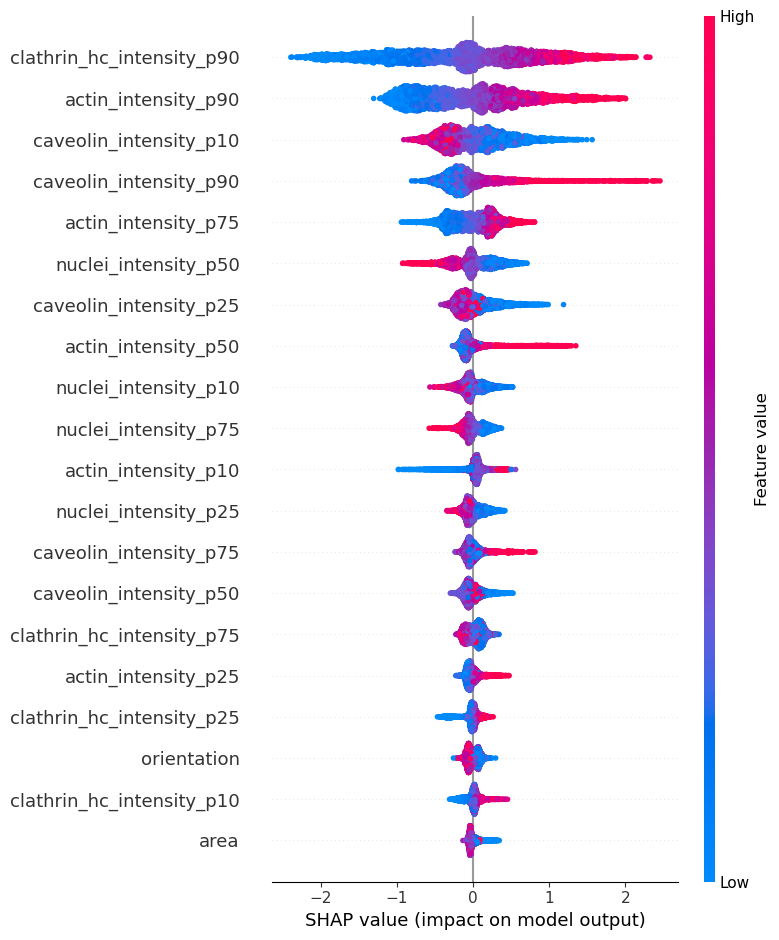

In [ ]:
print("SHAP values shape:", shap_values.shape)
print("SHAP values summary:", np.sum(np.isnan(shap_values)), np.sum(shap_values == 0))
shap.summary_plot(shap_values, X_test)
